In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchsummary import summary

from imageio import imread
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%config InlineBackend.figure_format = 'svg'

## import VGG19 and freeze all layers

In [147]:
vggnet = torchvision.models.vgg19(pretrained=True)

for p in vggnet.parameters():
    p.requires_grad=False

vggnet.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [148]:
device = torch.device('mps')

In [149]:
import cv2

## import images

In [150]:
vggnet.to(device);

In [151]:
torch.device('mps')

device(type='mps')

In [152]:
from PIL import Image


In [153]:
img4content = cv2.imread('content.png')
img4style   = cv2.imread('style.png')
import cv2

img4content = cv2.imread('content.png', cv2.IMREAD_UNCHANGED)
img4style = cv2.imread('style.png', cv2.IMREAD_UNCHANGED)

if img4content.shape[2] == 4:
    img4content = img4content[:, :, :3]  # Assuming BGR format
img4content = cv2.cvtColor(img4content, cv2.COLOR_BGR2RGB)

if img4style.shape[2] == 4:
    img4style = img4style[:, :, :3]  # Assuming BGR format
img4style = cv2.cvtColor(img4style, cv2.COLOR_BGR2RGB)


# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

(902, 1514, 3)
(902, 1514, 3)
(742, 1472, 3)


## Resizing images

In [154]:
## These images are really large, which will make training take a long time. 

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style   ).unsqueeze(0).to(device)
img4target  = Ts( img4target  ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 429])
torch.Size([1, 3, 256, 429])
torch.Size([1, 3, 256, 507])


# These are "Before" pics

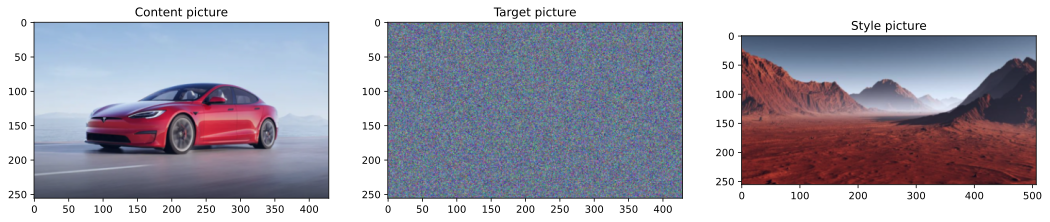

In [155]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

## Function to extract image feature map activations


In [156]:
# A function that return feature maps

def getFeatureMapActs(img,net):
    featuremaps = []
    featurenames = []

    convLayerIdx = 0
    #loop through all layers in the "features" block
    for layernum in range(len(net.features)):
        #print out info from this layer
        # print(layernum,net.features[layernum])
        # process the image through this layer
        img = net.features[layernum](img)

        # store the image if it's a conv2d layer
        if 'Conv2d' in str(net.features[layernum]):
            featuremaps.append(img)
            featurenames.append('ConvLayer_'+str(convLayerIdx))
            convLayerIdx += 1

    return featuremaps,featurenames

In [157]:
# Function that returns the Gram matrix of the feature activation map

def gram_matrix(M):
    #reshape to 2D
    _,chans,height,width = M.shape
    M = M.reshape(chans,height*width)
    #compute and return covariance matrix
    gram = torch.mm(M,M.t())/(chans*height*width)
    return gram

In [158]:
#inspect the output of the function
featuremaps, featurenames = getFeatureMapActs(img4content,vggnet)

#print out some infor
for i in range(len(featurenames)):
    print('Feature map "%s" is size %s'%(featurenames[i],(featuremaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 256, 429])
Feature map "ConvLayer_1" is size torch.Size([1, 64, 256, 429])
Feature map "ConvLayer_2" is size torch.Size([1, 128, 128, 214])
Feature map "ConvLayer_3" is size torch.Size([1, 128, 128, 214])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 64, 107])
Feature map "ConvLayer_5" is size torch.Size([1, 256, 64, 107])
Feature map "ConvLayer_6" is size torch.Size([1, 256, 64, 107])
Feature map "ConvLayer_7" is size torch.Size([1, 256, 64, 107])
Feature map "ConvLayer_8" is size torch.Size([1, 512, 32, 53])
Feature map "ConvLayer_9" is size torch.Size([1, 512, 32, 53])
Feature map "ConvLayer_10" is size torch.Size([1, 512, 32, 53])
Feature map "ConvLayer_11" is size torch.Size([1, 512, 32, 53])
Feature map "ConvLayer_12" is size torch.Size([1, 512, 16, 26])
Feature map "ConvLayer_13" is size torch.Size([1, 512, 16, 26])
Feature map "ConvLayer_14" is size torch.Size([1, 512, 16, 26])
Feature map "ConvLayer_15" is size torch

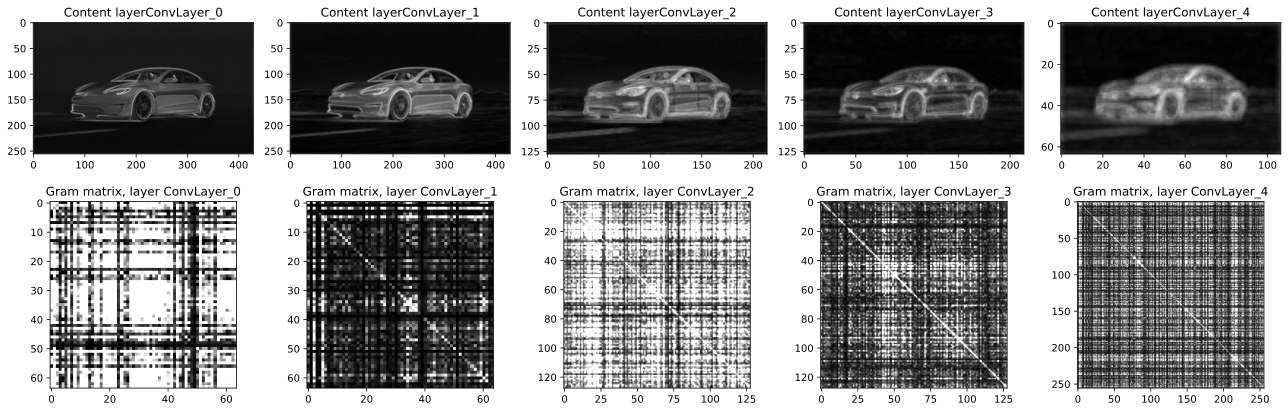

In [159]:
#lets see what the content image looks like
contentFeatureMaps, contentFeatureNames = getFeatureMapActs(img4content,vggnet)

fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):
    #avg over all feature maps from this layer, and normlize
    pic = np.mean(contentFeatureMaps[i].cpu().squeeze().numpy(),axis=0)
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[0,i].imshow(pic,cmap='gray')
    axs[0,i].set_title('Content layer' + str(contentFeatureNames[i]))

    ### now show the gram matrix
    pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[1,i].imshow(pic,cmap='gray',vmax=.1)
    axs[1,i].set_title('Gram matrix, layer '+str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

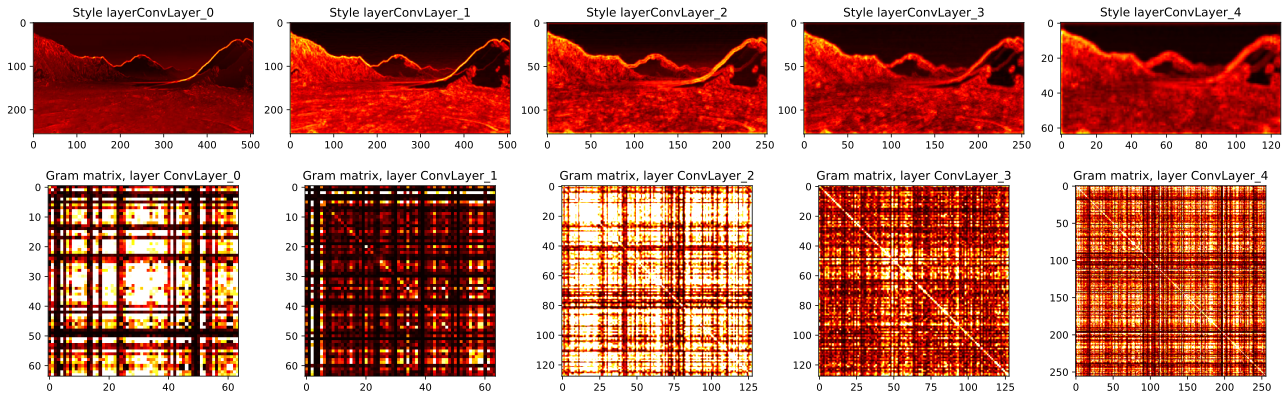

In [160]:
# repeat for the "style" image
styleFeatureMaps,styleFeatureNames = getFeatureMapActs(img4style,vggnet)
fig,axs = plt.subplots(2,5,figsize=(18,6))
for i in range(5):
    #avg over all feature maps from this layer, and normlize
    pic = np.mean(styleFeatureMaps[i].cpu().squeeze().numpy(),axis=0)
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[0,i].imshow(pic,cmap='hot')
    axs[0,i].set_title('Style layer' + str(styleFeatureNames[i]))

    ### now show the gram matrix
    pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
    pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

    axs[1,i].imshow(pic,cmap='hot',vmax=.1)
    axs[1,i].set_title('Gram matrix, layer '+str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

# Now the transfer

In [161]:
# which layers to use
layers4content = [ 'ConvLayer_1','ConvLayer_4' ]
layers4style   = [ 'ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4','ConvLayer_5' ]
weights4style  = [      1       ,     .0      ,     .0      ,     .0      ,     .0      ]

In [162]:
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'


In [163]:
# # make a copy of the target image and push to GPU
# target = img4target.clone()
# target.requires_grad=True
# target = target.to(device)
# styleScaling = 1e6

# #number of epochs to train
# numepochs = 1500
# #optimizer for backprop
# optimizer = torch.optim.RMSprop([target],lr=0.005)

# for epochi in range(numepochs):
#     #extract the target feature maps
#     targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,vggnet)
#     #initialize the indivisual loss components
#     styleLoss = 0
#     contentLoss = 0
#     #loop over layers
#     for layeri in range(len(targetFeatureNames)):
#         #compute the content loss
#         if targetFeatureNames[layeri] in layers4content:
#             contentLoss += torch.mean((targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2)
#         #compute the style loss
#         if targetFeatureNames[layeri] in layers4style:
#             #gram matrices
#             Gtarget = gram_matrix(targetFeatureMaps[layeri])
#             Gstyle = gram_matrix(styleFeatureMaps[layeri])

#             #compute their loss(de-weighted with increasing depth)
#             styleLoss += torch.mean((Gtarget-Gstyle)**2)*weights4style[layers4style.index(targetFeatureNames[layeri])]
#         #combined loss
#         styleScaling = torch.tensor(16).to(device)  # Assuming you use a device
#         styleLoss = styleLoss.float()  # Convert to float if not already
#         contentLoss = contentLoss.float()

#         combiloss = styleScaling * styleLoss + contentLoss


#         #finally ready for backprop
#         optimizer.zero_grad()
#         combiloss.backward()
#         optimizer.step()
# make a copy of the target image and push to GPU
target = img4target.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 1e6

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.005)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,vggnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:
      
      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]

  
  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()


In [164]:
# import os
# os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
# print("MPS High Watermark Ratio:", os.getenv('PYTORCH_MPS_HIGH_WATERMARK_RATIO'))


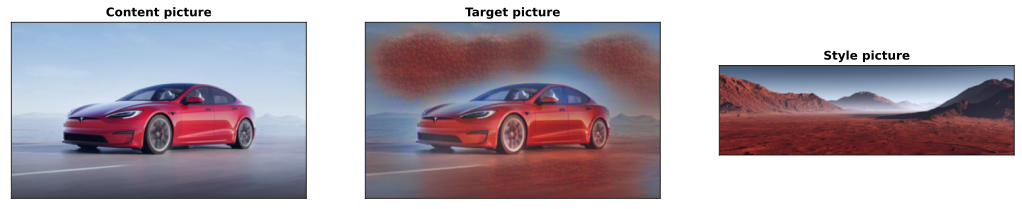

In [165]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic))/(np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])
plt.show()